In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from tsfresh import extract_features
import pmdarima as pm
from pmdarima import model_selection

warnings.filterwarnings("ignore")
plt.rcParams["font.size"] = 10


In [2]:

########## Load each data frame into dictionary - Permian ##########
file_names = ! ls permian_despiked_120523
dict_dfs = {}
for file_name in file_names:
    df=pd.read_csv(f'permian_despiked_120523/{file_name}')
    # remove_max=df[df['DEPTH(ft)']<=30].index.max()
    # array =np.empty((remove_max+1))
    # array[:] = np.nan
    # new_gamma = list(array) + list(df['Gamma(gapi)']) 
    # new_gamma= new_gamma[:-remove_max-1]
    # df['Gamma(gapi)_unlagged30'] = new_gamma
    dict_dfs[file_name]=df
    
# these are the cols of interest
consistent_col_names =['DEPTH(ft)',
 'ROP(ft / min)',
 'WOB(klbs)',
 'TPO(gal / min)',
 'RPM(rpm)',
 'SPP(psi)',
 'INC(deg)',
 'Gamma(gapi)',
 'DIFP(psi)']

df=dict_dfs[file_names[0]]
df=df[consistent_col_names].dropna() 

# get horz and vertical drilling separately
df_horz=df[df['INC(deg)']>80]
df_horz_orig = df_horz.copy()
# create ids to represent different windows -30ft
def add_ids(df):
    ids=[]
    window=60 #equivalent to 30ft
    id=0
    for i in range(1,len(df)+1):
        if (i/window).is_integer():
            id=i/window
            ids.append(id)
        else: 
            ids.append(id)
    df['id']=ids
    small_window=pd.Series(ids).value_counts()[pd.Series(ids).value_counts()<99].index[0]
    df= df[df['id']!=small_window] #remove small window
    df['id']=df['id'].astype(int)
    df['DEPTH(ft)_time']=df['DEPTH(ft)']
    return df
df_horz1=add_ids(df_horz)


In [3]:
# get one non-overlapping window
fc_settings = {'mean': None,'median': None,'minimum': None,'maximum': None,'root_mean_square':None,'standard_deviation':None}
df_features = extract_features(df_horz1, column_id="id", column_sort="DEPTH(ft)_time",default_fc_parameters=fc_settings)
df_features.columns


Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s]


Index(['DEPTH(ft)__mean', 'DEPTH(ft)__median', 'DEPTH(ft)__minimum',
       'DEPTH(ft)__maximum', 'DEPTH(ft)__root_mean_square',
       'DEPTH(ft)__standard_deviation', 'ROP(ft / min)__mean',
       'ROP(ft / min)__median', 'ROP(ft / min)__minimum',
       'ROP(ft / min)__maximum', 'ROP(ft / min)__root_mean_square',
       'ROP(ft / min)__standard_deviation', 'WOB(klbs)__mean',
       'WOB(klbs)__median', 'WOB(klbs)__minimum', 'WOB(klbs)__maximum',
       'WOB(klbs)__root_mean_square', 'WOB(klbs)__standard_deviation',
       'TPO(gal / min)__mean', 'TPO(gal / min)__median',
       'TPO(gal / min)__minimum', 'TPO(gal / min)__maximum',
       'TPO(gal / min)__root_mean_square',
       'TPO(gal / min)__standard_deviation', 'RPM(rpm)__mean',
       'RPM(rpm)__median', 'RPM(rpm)__minimum', 'RPM(rpm)__maximum',
       'RPM(rpm)__root_mean_square', 'RPM(rpm)__standard_deviation',
       'SPP(psi)__mean', 'SPP(psi)__median', 'SPP(psi)__minimum',
       'SPP(psi)__maximum', 'SPP(psi)__root_mean

In [4]:
### overlapping .5ft windows ###

fc_settings = {'mean': None,'median': None,'minimum': None,'maximum': None,'root_mean_square':None,'standard_deviation':None}
dfs=[]
for i in range(0,60):
    df_shift = add_ids(df_horz_orig.iloc[i:])
    df_features = extract_features(df_shift, column_id="id", column_sort="DEPTH(ft)_time",default_fc_parameters=fc_settings)
    dfs.append(df_features)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 18.01it/s]


In [53]:
# non-overlapping
# df=df_horz[:200].reset_index(drop=True)
df_res=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']]
for col in list(df_features.columns[df_features.columns.str.contains('Gamma')].str.replace('Gamma(gapi)__','')):
    df=df_features
    X = df[f'Gamma(gapi)__{col}'].values
    # split into train and test sets
    size = int(len(X) * 0.25)
    train, test = X[0:size], X[size:len(X)]
    history = list(train)
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t] #real obs
        history.append(obs)
    #  print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    # rmse = sqrt(mean_squared_error(test, predictions))
    # rmse='Test RMSE: %.3f' % rmse
    # plot forecasts against actual outcomes
    # fig, (ax,ax2)=plt.subplots(1,2,figsize=(10,8))
    # ax.plot(df_horz['Gamma(gapi)'],df_horz['DEPTH(ft)'], color='olivedrab',label='original')
    # ax.plot(pd.Series(X),df[f'DEPTH(ft)__{col}'],label=f'original 30ft {col}',color='navy',alpha=.8)
    # plt.plot(test)
    predictions=pd.Series(predictions)
    predictions.index=range(len(train),len(train)+len(predictions))
    df[f'pred__{col}']=predictions
    # ax.plot(df['pred'],df[f'DEPTH(ft)__{col}'], color='goldenrod',label=f'predicted 30ft {col}',alpha=1,linestyle='--')
    # ax.set_xlabel('Gamma (gapi)')
    # ax.set_ylabel('DEPTH (ft)')
    # ax.set_title('Training and predicted values')
    # ax.invert_yaxis()

    # ax2.plot(df_horz['Gamma(gapi)'],df_horz['DEPTH(ft)'], color='olivedrab',label='original')
    # ax2.plot(pd.Series(X),df[f'DEPTH(ft)__{col}'],label=f'original 30ft {col}',color='navy',alpha=.8)
    # plt.plot(test)
    # predictions=pd.Series(predictions)
    # predictions.index=range(len(train),len(train)+len(predictions))
    # df['pred']=predictions

    # ax2.plot(df['pred'],df[f'DEPTH(ft)__{col}'], color='goldenrod',label=f'predicted 30ft {col}',alpha=1,linestyle='--')
    # ax2.set_xlabel('Gamma (gapi)')
    # ax2.set_ylabel('DEPTH (ft)')
    # ax2.invert_yaxis()
    # ax2.legend(bbox_to_anchor=(1,1),frameon=False)
    # # ax2.set_ylim(13500,12500)
    # ax2.set_title('Zoom in on some predicted values')
    # plt.suptitle(f'ARIMA model ({rmse}) on horizontal data - {col} 30ft to predict {col} of next 30ft. New predictions are obtained every 30ft.\nBut if a sliding/overlapping window were applied it could predict every .5ft',x=.09,y=.93,horizontalalignment='left')
    # fig.tight_layout(rect=[0, 0, .9, 0.95])
    # convert agg data to raw shape
    pred_df=df[df[f'pred__{col}'].notna()]
    raws=pd.DataFrame()
    for i in range(0,pred_df.shape[0]):
        current_depth=pred_df[f'DEPTH(ft)__mean'].iloc[i]
        depth=np.concatenate([np.arange(current_depth-15,current_depth,.5),np.arange(current_depth,current_depth+15,.5)])
        raw=pd.DataFrame(depth,columns=['DEPTH(ft)'])
        raw[f'pred__{col}']=pred_df[f'pred__{col}'].iloc[i]
        raws=pd.concat([raws,raw])
    raws['DEPTH(ft)']=raws['DEPTH(ft)']-.25
    pred_df_raw=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(raws,on='DEPTH(ft)')
    df_res=df_res.merge(pred_df_raw,on=['DEPTH(ft)','Gamma(gapi)'])


In [16]:
# convert agg data to raw shape
pred_df=df[df[f'pred__{col}'].notna()]
raws=pd.DataFrame()
for i in range(0,pred_df.shape[0]):
    current_depth=pred_df[f'DEPTH(ft)__mean'].iloc[i]
    depth=np.concatenate([np.arange(current_depth-15,current_depth,.5),np.arange(current_depth,current_depth+15,.5)])
    raw=pd.DataFrame(depth,columns=['DEPTH(ft)'])
    raw[f'pred__{col}']=pred_df[f'pred__{col}'].iloc[i]
    raws=pd.concat([raws,raw])
raws['DEPTH(ft)']=raws['DEPTH(ft)']-.25
pred_df_raw=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(raws,on='DEPTH(ft)')
sqrt(mean_squared_error(pred_df_raw['Gamma(gapi)'], pred_df_raw['pred']))

19.515622690323276

In [141]:
## figs to show each feature and rmse of mean and orig. where fill in 

'Test RMSE: 24.135'

In [85]:
# non-overlapping
# df=df_horz[:200].reset_index(drop=True)
combine=pd.DataFrame(df_horz_orig['DEPTH(ft)'])
for df_features in dfs:
    df=df_features
    X = df['Gamma(gapi)__mean'].values
    # split into train and test sets
    size = int(len(X) * 0.25)
    train, test = X[0:size], X[size:len(X)]
    history = list(train)
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t] #real obs
        history.append(obs)

    predictions=pd.Series(predictions)
    predictions.index=range(len(train),len(train)+len(predictions))
    df['pred']=predictions
    df=df[['DEPTH(ft)__mean','Gamma(gapi)__mean','pred']]
    df=df.rename(columns={'DEPTH(ft)__mean':'DEPTH(ft)'})
    combine=pd.concat([df,combine])
combined=combine[combine['Gamma(gapi)__mean'].notna()].sort_values('DEPTH(ft)')

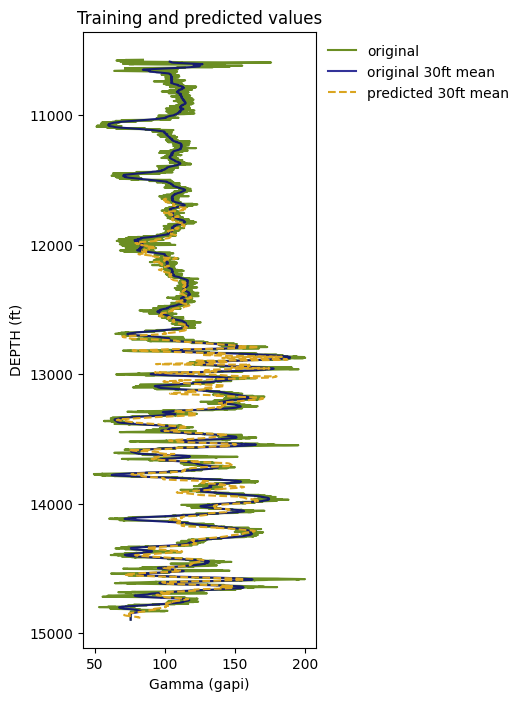

In [91]:
fig, ax=plt.subplots(figsize=(3,8))
ax.plot(df_horz_orig['Gamma(gapi)'],df_horz_orig['DEPTH(ft)'], color='olivedrab',label='original')
ax.plot(combined['Gamma(gapi)__mean'],combined['DEPTH(ft)'],label='original 30ft mean',color='navy',alpha=.8)
ax.plot(combined['pred'],combined['DEPTH(ft)'], color='goldenrod',label='predicted 30ft mean',alpha=1,linestyle='--')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
ax.set_title('Training and predicted values')
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1,1),frameon=False)
c=combined.dropna()
rmse = sqrt(mean_squared_error(c['Gamma(gapi)__mean'], c['pred']))

In [93]:
c=combined.dropna()
rmse = sqrt(mean_squared_error(c['Gamma(gapi)__mean'], c['pred']))

## Explore other gamma window features 

In [4]:
df_features_all = extract_features(df_horz1, column_id="id", column_sort="DEPTH(ft)_time")


Feature Extraction: 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


In [5]:
df_all_gamma_features=df_features_all[list(df_features_all.columns[df_features_all.columns.str.contains('Gamma')])+['DEPTH(ft)__mean']]


In [6]:

rmse={}
err=[]
for i in range(0,len(df_all_gamma_features.columns)-1):
    try: 
        df=df_all_gamma_features
        col=df.columns[i]
        X = df[col].values
        # split into train and test sets
        size = int(len(X) * 0.25)
        train, test = X[0:size], X[size:len(X)]
        history = list(train)
        predictions = list()
        # walk-forward validation
        for t in range(len(test)):
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t] #real obs
            history.append(obs)
        predictions=pd.Series(predictions)
        predictions.index=range(len(train),len(train)+len(predictions))
        df['pred']=predictions
        # evaluate forecasts
        # convert agg data to raw shape
        pred_df=df[df['pred'].notna()]
        raws=pd.DataFrame()
        for i in range(0,pred_df.shape[0]):
            current_depth=pred_df['DEPTH(ft)__mean'].iloc[i]
            depth=np.concatenate([np.arange(current_depth-15,current_depth,.5),np.arange(current_depth,current_depth+15,.5)])
            raw=pd.DataFrame(depth,columns=['DEPTH(ft)'])
            raw['pred']=pred_df['pred'].iloc[i]
            raws=pd.concat([raws,raw])
        raws['DEPTH(ft)']=raws['DEPTH(ft)']-.25
        pred_df_raw=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(raws,on='DEPTH(ft)')
        rmse[col]=sqrt(mean_squared_error(pred_df_raw['Gamma(gapi)'], pred_df_raw['pred']))
    except:
        err.append(col)
    
rmse=pd.DataFrame(rmse,index=[0]).T.reset_index()
rmse.columns=['feature','rmse']
fn=file_names[0].replace('.csv','')
rmse.to_csv(f'results/{fn}_30ftwindow_nonoverlap_all_features_gamma.csv')
if len(err)!=0:
    pd.Series(err).to_csv(f'results/{fn}_errors_30ftwindow_nonoverlap_all_features_gamma.csv')

In [17]:
a=pd.read_csv(f'results/{fn}_30ftwindow_nonoverlap_all_features_gamma.csv',index_col=[0])
a.sort_values('rmse').iloc[0:20]

,feature,rmse
87,Gamma(gapi)__quantile__q_0.6,19.259777
9,Gamma(gapi)__median,19.515623
16,Gamma(gapi)__root_mean_square,19.638602
428,"Gamma(gapi)__agg_linear_trend__attr_""intercept...",19.688837
88,Gamma(gapi)__quantile__q_0.7,19.856873
10,Gamma(gapi)__mean,19.920015
86,Gamma(gapi)__quantile__q_0.4,21.154548
89,Gamma(gapi)__quantile__q_0.8,21.638145
85,Gamma(gapi)__quantile__q_0.3,22.621749
90,Gamma(gapi)__quantile__q_0.9,24.024807


In [8]:
pd.read_csv(f'results/{fn}_errors_30ftwindow_nonoverlap_all_features_gamma.csv',index_col=[0])

,0
0,Gamma(gapi)__variance
1,Gamma(gapi)__partial_autocorrelation__lag_6
2,Gamma(gapi)__spkt_welch_density__coeff_2
3,"Gamma(gapi)__fft_coefficient__attr_""real""__coe..."
4,"Gamma(gapi)__fft_coefficient__attr_""real""__coe..."
...,...
282,"Gamma(gapi)__fft_coefficient__attr_""angle""__co..."
283,Gamma(gapi)__max_langevin_fixed_point__m_3__r_30
284,"Gamma(gapi)__agg_linear_trend__attr_""intercept..."
285,"Gamma(gapi)__agg_linear_trend__attr_""slope""__c..."


In [17]:
### do overlapping window with combined features!! 
combine=pd.DataFrame(df_horz_orig['DEPTH(ft)'])
for df_features in dfs:
    df_feature= df_features[['DEPTH(ft)__mean']+list(df_features.columns[df_features.columns.str.contains('Gamma')])]
    size=int(len(df_feature) * 0.25)
    train=df_feature[:size]
    test=df_feature[size:]

    # Fit a simple auto_arima model
    arima = pm.auto_arima(train['Gamma(gapi)__mean'],X=train.drop(columns=['DEPTH(ft)__mean','Gamma(gapi)__mean']), d=2,error_action='ignore', trace=False,
                        suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')
    pred=arima.predict(n_periods=108, X=test.drop(columns=['DEPTH(ft)__mean','Gamma(gapi)__mean']), alpha=0.05)
    prediction=pd.DataFrame(pred).reset_index(drop=True)
    df=test.reset_index(drop=True)
    df['pred']=prediction[0]
    df=df[['DEPTH(ft)__mean','Gamma(gapi)__mean','pred']]
    df=df.rename(columns={'DEPTH(ft)__mean':'DEPTH(ft)'})
    combine=pd.concat([df,combine])
combined=combine[combine['Gamma(gapi)__mean'].notna()].sort_values('DEPTH(ft)')

    # # # convert agg data to raw shape
    # # pred_df=test
    # # raws=pd.DataFrame()
    # # for i in range(0,pred_df.shape[0]):
    # #     current_depth=pred_df[f'DEPTH(ft)__mean'].iloc[i]
    # #     depth=np.concatenate([np.arange(current_depth-15,current_depth,.5),np.arange(current_depth,current_depth+15,.5)])
    # #     raw=pd.DataFrame(depth,columns=['DEPTH(ft)'])
    # #     raw['Prediction']=pred_df['Prediction'].iloc[i]
    # #     raws=pd.concat([raws,raw])
    # # raws['DEPTH(ft)']=raws['DEPTH(ft)']-.25
    # # pred_df_raw=df_horz_orig[['DEPTH(ft)','Gamma(gapi)']].merge(raws,on='DEPTH(ft)').dropna()
    # rmse=sqrt(mean_squared_error(pred_df_raw['Gamma(gapi)'], pred_df_raw['Prediction']))
    
    

In [20]:
combined

,DEPTH(ft),Gamma(gapi)__mean,pred
0,11642.25,104.823533,104.700257
0,11642.75,104.905010,104.925271
0,11643.25,105.138130,105.170215
0,11643.75,105.323528,105.313159
0,11644.25,105.411403,105.469269
...,...,...,...
107,14896.00,75.618300,82.946016
107,14896.25,75.618300,85.995654
107,14896.50,75.618300,106.041134
107,14896.75,75.618300,92.912492


4.0960639606391505


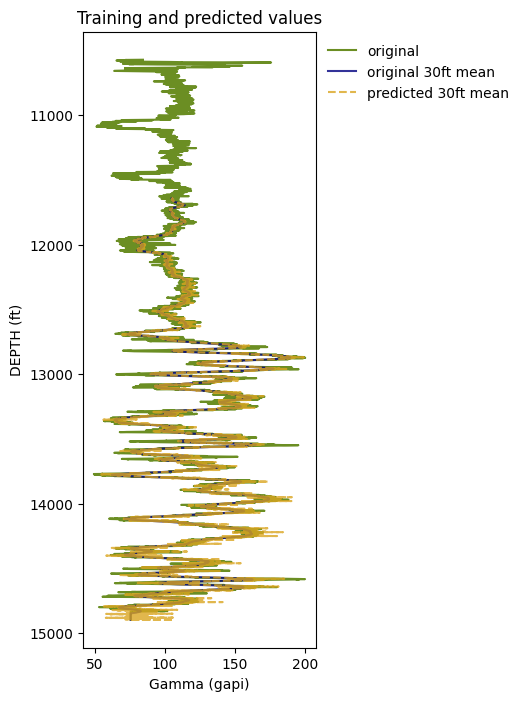

In [19]:
fig, ax=plt.subplots(figsize=(3,8))
ax.plot(df_horz_orig['Gamma(gapi)'],df_horz_orig['DEPTH(ft)'], color='olivedrab',label='original')
ax.plot(combined['Gamma(gapi)__mean'],combined['DEPTH(ft)'],label='original 30ft mean',color='navy',alpha=.8)
ax.plot(combined['pred'],combined['DEPTH(ft)'], color='goldenrod',label='predicted 30ft mean',alpha=.8,linestyle='--')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
ax.set_title('Training and predicted values')
ax.invert_yaxis()
ax.legend(bbox_to_anchor=(1,1),frameon=False)
c=combined.dropna()
rmse = sqrt(mean_squared_error(c['Gamma(gapi)__mean'], c['pred']))
print(rmse)


In [ ]:
## check that combined represents raw data shape
